In [7]:
import glob
import networkx as nx 
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
import torch, torch_geometric
from torch_geometric.data import Dataset, DenseDataLoader, Data
import torch.nn.functional as F
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
import os.path as osp
from math import ceil
from Variables import *
from sklearn.metrics import confusion_matrix

import io
import string
import seaborn as sns
from flask import Flask, jsonify, request, render_template

In [8]:
def Variables(edge_file):

    node250_df = pd.read_csv(r"C:\Users\Vishnu\Documents\ijhdfbgjws\node\freesurfer_thickness_fsaverage_smoothing10_size250_edgeweight_manhattan_graynet-nodes1.csv")
    node250 = node250_df.iloc[:, 2:]
    dat250 = node250_df.set_index('~id').to_dict('index').items()

    x250 = glob.glob(edge_file)

    y250 = np.zeros(shape=(118, 1))
    nf250_array = []

    for count in range(118):
        nf250_array.append(node250)
    
    y_df = pd.read_csv(r"C:\Users\Vishnu\Documents\y_label.csv")
    y = y_df.to_numpy()

    p250 = []
    k250 = []

    for count in range(len(x250)):
        f = pd.read_csv(x250[count], error_bad_lines=False, encoding='latin1')
        f.fillna(0.0001)

        if len(f) == 674541:
            G = nx.from_pandas_edgelist(f, '~from', '~to', edge_attr=True)
            G.add_nodes_from(dat250)
            p250.append(nx.convert_matrix.to_numpy_array(G, weight = 'd3:double'))
            k250.append(x250[count])
            
    adj = (np.array(p250))
    X = (np.array(nf250_array))
    edge_index = pd.read_excel( r"C:\Users\Vishnu\Documents\COOsparse1.xlsx", engine='openpyxl')
    
    
    return adj, X, y

In [9]:
adj, X, y = Variables(r"C:\Users\Vishnu\Documents\Edges\250_nodal\*.csv")


In [10]:
class Alzheimers(torch.utils.data.Dataset):
    def __init__(self, X, adj, y):
        
        self.y = torch.tensor(y, dtype=torch.long)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.adj = torch.tensor(adj, dtype=torch.float32)
#         self.edge = edge.type(torch.LongTensor)
        

    def __len__(self):
        return(len(self.y))

    def __num_classes__(self):
        return len('ar')

    def __getitem__(self, idx):

        x = self.X[idx]
        adj = self.adj[idx]
#         edge_index = self.edge[idx].type(torch.LongTensor)
        y = self.y[idx]
        num_features = 3 

        return torch_geometric.data.Data(x=x, adj=adj, y=y, mask=None)
#         return {'x': x, 'adj': adj, 'edge_index': edge_index, 'y':y}
    
dataset = Alzheimers(X, adj, y)
print(len(dataset))

118


In [11]:
num_instances = len(dataset)
test_ratio = 0.3
test_size = int(num_instances * test_ratio)
train_size = num_instances - test_size

device = torch.device('cpu')
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 3000

train_data, test_data = torch.utils.data.random_split(dataset, (train_size, test_size))

train_loader = DenseDataLoader(train_data, **params)
test_loader = DenseDataLoader(test_data, **params)

In [12]:

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        self.conv1 = DenseSAGEConv(in_channels, hidden_channels, normalize)
#         self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = DenseSAGEConv(hidden_channels, hidden_channels, normalize)
#         self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = DenseSAGEConv(hidden_channels, out_channels, normalize)
#         self.bn3 = torch.nn.BatchNorm1d(out_channels)

        if lin is True:
            self.lin = torch.nn.Linear(2 * hidden_channels + out_channels,
                                       out_channels)
        else:
            self.lin = None


    def forward(self, x, adj, mask=None):
#         batch_size, num_nodes, in_channels = x.size()

        x0 = x
        x1 = F.relu(self.conv1(x0, adj, mask))
        x2 = F.relu(self.conv2(x1, adj, mask))
        x3 = F.relu(self.conv3(x2, adj, mask))

        x = torch.cat([x1, x2, x3], dim=-1)

        if self.lin is not None:
            x = F.relu(self.lin(x))

        return x

    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        max_nodes = 1162
        
        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(3, 64, num_nodes)
        self.gnn1_embed = GNN(3, 64, 64, lin=False)
        
        
        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(3 * 64, 64, num_nodes)
        self.gnn2_embed = GNN(3 * 64, 64, 64, lin=False)

        
        num_nodes = ceil(0.25 * num_nodes)
        self.gnn3_pool = GNN(3 * 64, 64, num_nodes)
        self.gnn3_embed = GNN(3 * 64, 64, 64, lin=False)

        
        self.lin1 = torch.nn.Linear(3 * 64, 64)
        self.lin2 = torch.nn.Linear(64, 64)
        self.lin3 = torch.nn.Linear(64, 6)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask=None)
        x = self.gnn1_embed(x, adj, mask=None)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask=None)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        s = self.gnn3_pool(x, adj)
        x = self.gnn3_embed(x, adj)
        
        x, adj, l3, e3 = dense_diff_pool(x, adj, s)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2 + l3, e1 + e2 + e3


In [13]:
device='cpu'
model = Net().to(device)
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.0001)

In [14]:
model.load_state_dict(torch.load('./fix_vishnunet17.pth'))

<All keys matched successfully>

In [21]:
nb_classes = 2
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)


with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj)
        _, preds = torch.max(output, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,data.y.view(-1)])

AxesSubplot(0.125,0.125;0.62x0.755)


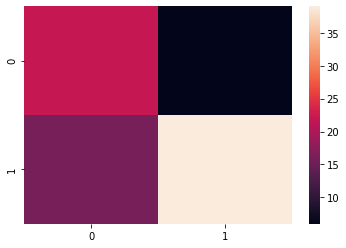

In [22]:
cm = confusion_matrix(predlist.numpy(), lbllist.numpy())
# cm = (100/83)*cm
print(sns.heatmap(cm))

In [24]:
print((cm))

[[22  6]
 [16 39]]
